In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
print(tf.__version__)

1.3.0


In [2]:
import dcgan_helper

data_dir = './data'
dcgan_helper.download_extract('celeba', data_dir)

Found celeba Data


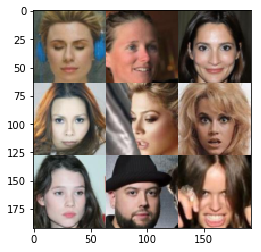

In [3]:
show_n_images = 10
mnist_images = dcgan_helper.get_batch(
    glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 64, 64, 'RGB')
plt.imshow(dcgan_helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, 
                                 shape=(None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_inputs, z_inputs, learning_rate

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # image: 64x64x3
        x = tf.layers.conv2d(images, 128, kernel_size=3, strides=2, 
                             padding='same', activation=None)
        x = tf.maximum(alpha * x, x)
        # 32x32x128 now
        #print("conv1: ", x.shape)
        
        x = tf.layers.conv2d(x, 256, kernel_size=3, strides=2, 
                             padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 16x16x256 now
        #print("conv2: ", x.shape)
        
        x = tf.layers.conv2d(x, 512, kernel_size=3, strides=2, 
                             padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 8x8x512 now
        #print("conv3: ", x.shape)
        
        x = tf.layers.conv2d(x, 1024, kernel_size=3, strides=2, 
                             padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 4x4x1024 now
        #print("conv4: ", x.shape)
        
        flat = tf.reshape(x, [-1, 4*4*1024])
        logits = tf.layers.dense(flat, 1, activation=None, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)

    return out, logits

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # z: (100,)
        x = tf.layers.dense(z, 4*4*1024, activation=None,
                           kernel_initializer=tf.contrib.layers.xavier_initializer())        
        x = tf.reshape(x, shape=[-1,4,4,1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.relu(x)
        # 4x4x1024 now
        #print("x: ", x.shape)
        
        conv1 = tf.layers.conv2d_transpose(
            x, 512, kernel_size=3, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.nn.relu(conv1)
        # 8x8x512 now
        #print("conv1: ", conv1.shape)
        
        conv2 = tf.layers.conv2d_transpose(
            conv1, 256, kernel_size=3, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.nn.relu(conv2)
        # 16x16x256 now
        #print("conv2: ", conv2.shape)
        
        conv3 = tf.layers.conv2d_transpose(
            conv2, 128, kernel_size=3, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.nn.relu(conv3)
        # 32x32x128 now
        #print("conv3: ", conv3.shape)
        
        # Output layer, 64x64x3
        logits = tf.layers.conv2d_transpose(
            conv3, out_channel_dim, kernel_size=3, strides=2, padding='same', activation=None, 
            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 64x64x3 now
        #print("logits: ", logits.shape)
        
        out = tf.tanh(logits)
        
    return out

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    '''
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    '''
    
    eps = sys.float_info.epsilon
    g_loss = tf.reduce_mean(-tf.log(d_model_fake + eps))
    d_loss = tf.reduce_mean(-tf.log(d_model_real + eps) - tf.log(1 - d_model_fake + eps))

    return d_loss, g_loss

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [9]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = dcgan_helper.images_square_grid(samples, image_mode)
    #plt.figure(figsize=(8,8))
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 600 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
            saver.save(sess, "./checkpoints/generator-{:2}.ckpt".format(epoch_i))

(202599, 64, 64, 3)
Epoch 1/20... Discriminator Loss: 1.6041... Generator Loss: 0.6431
Epoch 1/20... Discriminator Loss: 1.4451... Generator Loss: 0.8753
Epoch 1/20... Discriminator Loss: 1.3899... Generator Loss: 0.5936
Epoch 1/20... Discriminator Loss: 1.4137... Generator Loss: 1.0716
Epoch 1/20... Discriminator Loss: 1.4900... Generator Loss: 0.7065
Epoch 1/20... Discriminator Loss: 1.5219... Generator Loss: 0.4875


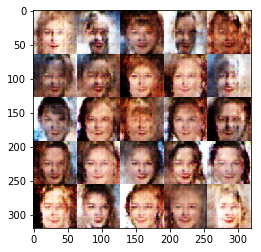

Epoch 1/20... Discriminator Loss: 1.4485... Generator Loss: 0.7627
Epoch 1/20... Discriminator Loss: 1.3890... Generator Loss: 0.5633
Epoch 1/20... Discriminator Loss: 1.5339... Generator Loss: 0.5941
Epoch 1/20... Discriminator Loss: 1.4622... Generator Loss: 0.6816
Epoch 1/20... Discriminator Loss: 1.4904... Generator Loss: 0.5921
Epoch 1/20... Discriminator Loss: 1.4419... Generator Loss: 0.5944


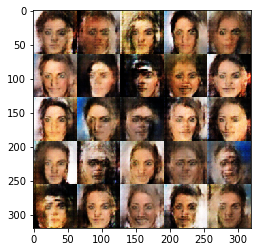

Epoch 1/20... Discriminator Loss: 1.3689... Generator Loss: 0.5907
Epoch 1/20... Discriminator Loss: 1.4666... Generator Loss: 0.8544
Epoch 1/20... Discriminator Loss: 1.3926... Generator Loss: 0.6083
Epoch 2/20... Discriminator Loss: 1.6472... Generator Loss: 0.6423
Epoch 2/20... Discriminator Loss: 1.4786... Generator Loss: 0.5942
Epoch 2/20... Discriminator Loss: 1.4205... Generator Loss: 0.8294


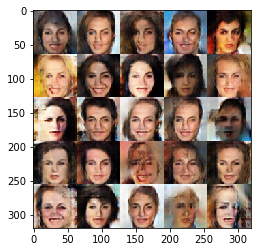

Epoch 2/20... Discriminator Loss: 1.6086... Generator Loss: 0.4493
Epoch 2/20... Discriminator Loss: 1.5980... Generator Loss: 1.0616
Epoch 2/20... Discriminator Loss: 2.0712... Generator Loss: 0.1765
Epoch 2/20... Discriminator Loss: 1.4220... Generator Loss: 0.8535
Epoch 2/20... Discriminator Loss: 1.4317... Generator Loss: 0.6383
Epoch 2/20... Discriminator Loss: 1.4961... Generator Loss: 0.5674


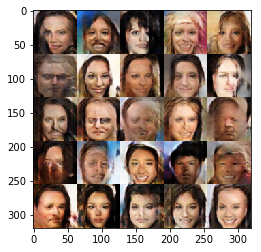

Epoch 2/20... Discriminator Loss: 1.4877... Generator Loss: 0.8002
Epoch 2/20... Discriminator Loss: 1.5176... Generator Loss: 0.4678
Epoch 2/20... Discriminator Loss: 1.4577... Generator Loss: 0.5795
Epoch 2/20... Discriminator Loss: 1.5338... Generator Loss: 0.7680
Epoch 2/20... Discriminator Loss: 1.4957... Generator Loss: 0.5303
Epoch 2/20... Discriminator Loss: 1.5350... Generator Loss: 0.5974


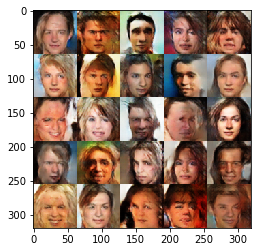

Epoch 2/20... Discriminator Loss: 1.4150... Generator Loss: 0.5616
Epoch 3/20... Discriminator Loss: 1.4514... Generator Loss: 0.6326
Epoch 3/20... Discriminator Loss: 1.4263... Generator Loss: 0.7713
Epoch 3/20... Discriminator Loss: 1.4247... Generator Loss: 0.5774
Epoch 3/20... Discriminator Loss: 1.4440... Generator Loss: 0.6377
Epoch 3/20... Discriminator Loss: 1.5073... Generator Loss: 0.5787


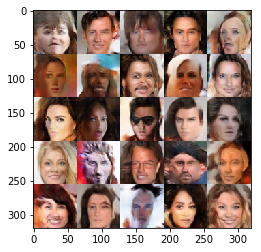

Epoch 3/20... Discriminator Loss: 1.6305... Generator Loss: 0.3694
Epoch 3/20... Discriminator Loss: 1.4236... Generator Loss: 0.5666
Epoch 3/20... Discriminator Loss: 1.4788... Generator Loss: 0.5751
Epoch 3/20... Discriminator Loss: 1.4957... Generator Loss: 0.3981
Epoch 3/20... Discriminator Loss: 1.6678... Generator Loss: 0.3722
Epoch 3/20... Discriminator Loss: 1.5766... Generator Loss: 0.3636


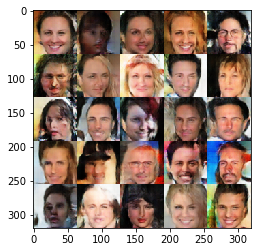

Epoch 3/20... Discriminator Loss: 1.5041... Generator Loss: 0.5208
Epoch 3/20... Discriminator Loss: 1.5832... Generator Loss: 0.5070
Epoch 3/20... Discriminator Loss: 1.4426... Generator Loss: 0.6868
Epoch 3/20... Discriminator Loss: 1.4760... Generator Loss: 0.6759
Epoch 3/20... Discriminator Loss: 1.6651... Generator Loss: 1.1009
Epoch 4/20... Discriminator Loss: 2.1465... Generator Loss: 0.1489


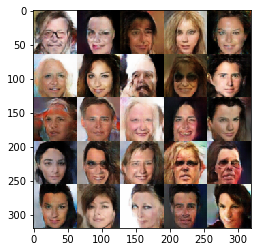

Epoch 4/20... Discriminator Loss: 1.4635... Generator Loss: 0.5175
Epoch 4/20... Discriminator Loss: 1.3603... Generator Loss: 0.9604
Epoch 4/20... Discriminator Loss: 1.4541... Generator Loss: 0.5476
Epoch 4/20... Discriminator Loss: 1.4187... Generator Loss: 0.7135
Epoch 4/20... Discriminator Loss: 1.6563... Generator Loss: 0.4214
Epoch 4/20... Discriminator Loss: 1.4488... Generator Loss: 0.4423


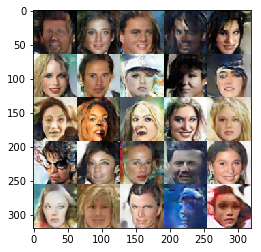

Epoch 4/20... Discriminator Loss: 1.2862... Generator Loss: 0.6060
Epoch 4/20... Discriminator Loss: 1.4481... Generator Loss: 1.0644
Epoch 4/20... Discriminator Loss: 1.6370... Generator Loss: 0.3029
Epoch 4/20... Discriminator Loss: 1.5698... Generator Loss: 0.4233
Epoch 4/20... Discriminator Loss: 1.6561... Generator Loss: 0.3417
Epoch 4/20... Discriminator Loss: 1.8834... Generator Loss: 0.2168


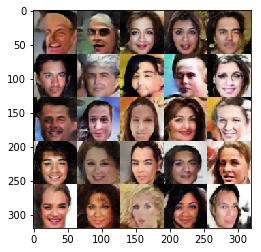

Epoch 4/20... Discriminator Loss: 1.4897... Generator Loss: 0.4301
Epoch 4/20... Discriminator Loss: 1.5038... Generator Loss: 0.3911
Epoch 4/20... Discriminator Loss: 1.6294... Generator Loss: 0.3022
Epoch 5/20... Discriminator Loss: 1.3766... Generator Loss: 0.4036
Epoch 5/20... Discriminator Loss: 1.1480... Generator Loss: 0.8367
Epoch 5/20... Discriminator Loss: 1.2745... Generator Loss: 0.5200


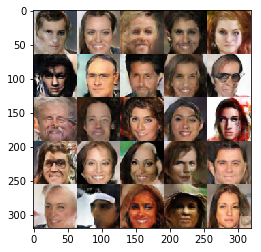

Epoch 5/20... Discriminator Loss: 1.1451... Generator Loss: 0.9375
Epoch 5/20... Discriminator Loss: 1.4598... Generator Loss: 0.3803
Epoch 5/20... Discriminator Loss: 1.9428... Generator Loss: 0.1898
Epoch 5/20... Discriminator Loss: 1.3412... Generator Loss: 0.4438
Epoch 5/20... Discriminator Loss: 1.0019... Generator Loss: 1.4847
Epoch 5/20... Discriminator Loss: 2.5731... Generator Loss: 0.0984


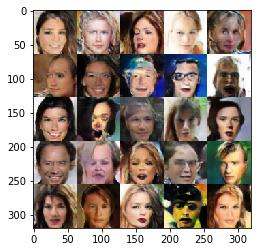

Epoch 5/20... Discriminator Loss: 1.4859... Generator Loss: 0.3536
Epoch 5/20... Discriminator Loss: 1.8398... Generator Loss: 0.2426
Epoch 5/20... Discriminator Loss: 1.0545... Generator Loss: 1.0413
Epoch 5/20... Discriminator Loss: 1.9241... Generator Loss: 0.2175
Epoch 5/20... Discriminator Loss: 1.4468... Generator Loss: 0.4669
Epoch 5/20... Discriminator Loss: 0.9209... Generator Loss: 1.0823


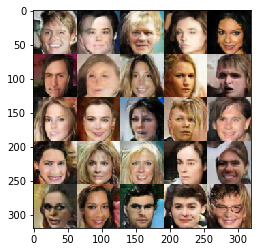

Epoch 5/20... Discriminator Loss: 1.1029... Generator Loss: 0.6426
Epoch 6/20... Discriminator Loss: 1.8554... Generator Loss: 0.2063
Epoch 6/20... Discriminator Loss: 0.6903... Generator Loss: 1.3153
Epoch 6/20... Discriminator Loss: 1.9256... Generator Loss: 0.1939
Epoch 6/20... Discriminator Loss: 1.1338... Generator Loss: 0.5833
Epoch 6/20... Discriminator Loss: 1.4519... Generator Loss: 0.3272


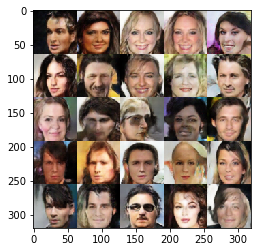

Epoch 6/20... Discriminator Loss: 2.1972... Generator Loss: 0.1496
Epoch 6/20... Discriminator Loss: 0.7260... Generator Loss: 0.9357
Epoch 6/20... Discriminator Loss: 0.7273... Generator Loss: 1.0836
Epoch 6/20... Discriminator Loss: 0.9177... Generator Loss: 0.7376
Epoch 6/20... Discriminator Loss: 1.4095... Generator Loss: 3.0051
Epoch 6/20... Discriminator Loss: 1.6813... Generator Loss: 0.3002


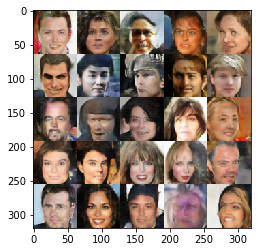

Epoch 6/20... Discriminator Loss: 1.2493... Generator Loss: 0.5294
Epoch 6/20... Discriminator Loss: 3.3604... Generator Loss: 3.3319
Epoch 6/20... Discriminator Loss: 0.6228... Generator Loss: 1.4292
Epoch 6/20... Discriminator Loss: 0.6986... Generator Loss: 2.4182
Epoch 7/20... Discriminator Loss: 0.5077... Generator Loss: 1.5498
Epoch 7/20... Discriminator Loss: 0.6783... Generator Loss: 2.0795


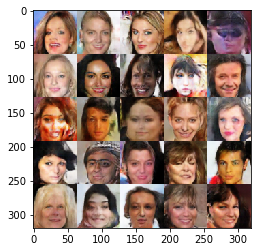

Epoch 7/20... Discriminator Loss: 2.1151... Generator Loss: 0.1614
Epoch 7/20... Discriminator Loss: 2.3190... Generator Loss: 0.1330
Epoch 7/20... Discriminator Loss: 1.7115... Generator Loss: 0.2755
Epoch 7/20... Discriminator Loss: 1.0061... Generator Loss: 0.7226
Epoch 7/20... Discriminator Loss: 1.0133... Generator Loss: 1.0720
Epoch 7/20... Discriminator Loss: 2.3550... Generator Loss: 0.1308


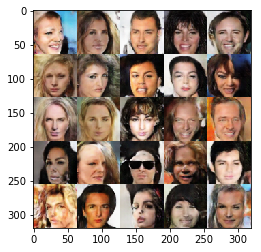

Epoch 7/20... Discriminator Loss: 2.0117... Generator Loss: 0.1897
Epoch 7/20... Discriminator Loss: 1.3428... Generator Loss: 0.4690
Epoch 7/20... Discriminator Loss: 0.7696... Generator Loss: 1.8400
Epoch 7/20... Discriminator Loss: 2.0269... Generator Loss: 0.2245
Epoch 7/20... Discriminator Loss: 0.9317... Generator Loss: 0.7199
Epoch 7/20... Discriminator Loss: 1.5250... Generator Loss: 0.3375


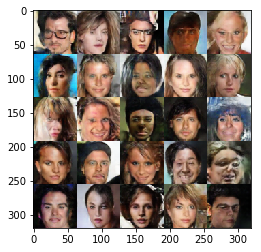

Epoch 7/20... Discriminator Loss: 0.7292... Generator Loss: 1.2123
Epoch 7/20... Discriminator Loss: 1.5922... Generator Loss: 0.3336
Epoch 8/20... Discriminator Loss: 0.9735... Generator Loss: 0.7300
Epoch 8/20... Discriminator Loss: 1.3777... Generator Loss: 0.4370
Epoch 8/20... Discriminator Loss: 1.7362... Generator Loss: 3.6819
Epoch 8/20... Discriminator Loss: 0.8201... Generator Loss: 0.9421


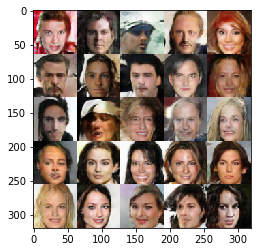

Epoch 8/20... Discriminator Loss: 1.0627... Generator Loss: 0.6809
Epoch 8/20... Discriminator Loss: 0.4564... Generator Loss: 1.5323
Epoch 8/20... Discriminator Loss: 1.0942... Generator Loss: 1.7602
Epoch 8/20... Discriminator Loss: 0.8800... Generator Loss: 2.0079
Epoch 8/20... Discriminator Loss: 0.9609... Generator Loss: 0.6876
Epoch 8/20... Discriminator Loss: 0.6362... Generator Loss: 1.1224


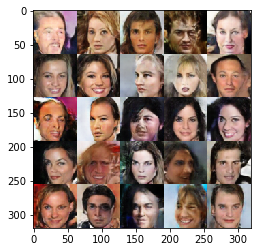

Epoch 8/20... Discriminator Loss: 1.3541... Generator Loss: 0.4499
Epoch 8/20... Discriminator Loss: 0.6614... Generator Loss: 3.0325
Epoch 8/20... Discriminator Loss: 2.2559... Generator Loss: 0.1572
Epoch 8/20... Discriminator Loss: 1.3294... Generator Loss: 0.5221
Epoch 8/20... Discriminator Loss: 1.0408... Generator Loss: 0.7356
Epoch 8/20... Discriminator Loss: 0.5698... Generator Loss: 1.1969


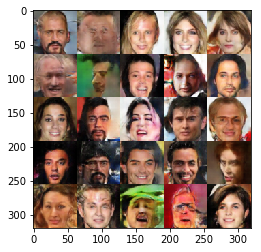

Epoch 9/20... Discriminator Loss: 1.9620... Generator Loss: 0.2422
Epoch 9/20... Discriminator Loss: 1.8984... Generator Loss: 0.2633
Epoch 9/20... Discriminator Loss: 0.6752... Generator Loss: 2.1611
Epoch 9/20... Discriminator Loss: 1.7109... Generator Loss: 0.3133
Epoch 9/20... Discriminator Loss: 0.4642... Generator Loss: 1.3775
Epoch 9/20... Discriminator Loss: 1.3400... Generator Loss: 0.5169


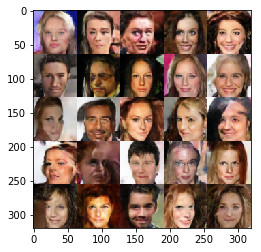

Epoch 9/20... Discriminator Loss: 2.1008... Generator Loss: 0.1789
Epoch 9/20... Discriminator Loss: 0.4225... Generator Loss: 1.8397
Epoch 9/20... Discriminator Loss: 1.1792... Generator Loss: 0.5709
Epoch 9/20... Discriminator Loss: 1.5690... Generator Loss: 0.3613
Epoch 9/20... Discriminator Loss: 1.4937... Generator Loss: 0.4294
Epoch 9/20... Discriminator Loss: 1.5391... Generator Loss: 0.3948


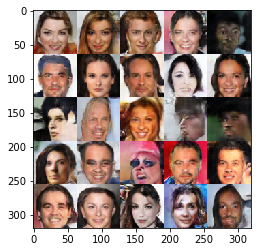

Epoch 9/20... Discriminator Loss: 1.6697... Generator Loss: 0.2974
Epoch 9/20... Discriminator Loss: 0.7183... Generator Loss: 1.1798
Epoch 9/20... Discriminator Loss: 1.9470... Generator Loss: 0.2786
Epoch 9/20... Discriminator Loss: 0.8211... Generator Loss: 0.9115
Epoch 10/20... Discriminator Loss: 1.1610... Generator Loss: 0.5395
Epoch 10/20... Discriminator Loss: 3.8599... Generator Loss: 6.6918


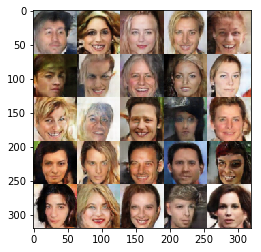

Epoch 10/20... Discriminator Loss: 1.4244... Generator Loss: 0.4226
Epoch 10/20... Discriminator Loss: 1.4524... Generator Loss: 0.4442
Epoch 10/20... Discriminator Loss: 0.7433... Generator Loss: 1.1294
Epoch 10/20... Discriminator Loss: 1.5123... Generator Loss: 3.8408
Epoch 10/20... Discriminator Loss: 0.5558... Generator Loss: 1.6358
Epoch 10/20... Discriminator Loss: 0.7058... Generator Loss: 1.0896


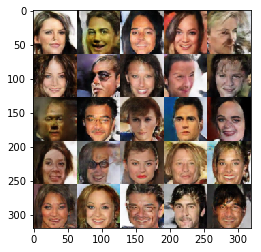

Epoch 10/20... Discriminator Loss: 1.3270... Generator Loss: 0.5866
Epoch 10/20... Discriminator Loss: 1.1841... Generator Loss: 0.5581
Epoch 10/20... Discriminator Loss: 2.6226... Generator Loss: 6.3119
Epoch 10/20... Discriminator Loss: 0.7096... Generator Loss: 1.9766
Epoch 10/20... Discriminator Loss: 1.6834... Generator Loss: 0.3645
Epoch 10/20... Discriminator Loss: 0.3525... Generator Loss: 1.8154


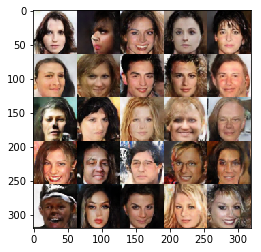

Epoch 10/20... Discriminator Loss: 1.3664... Generator Loss: 0.4438
Epoch 10/20... Discriminator Loss: 0.7582... Generator Loss: 1.0025
Epoch 11/20... Discriminator Loss: 1.5062... Generator Loss: 0.4191
Epoch 11/20... Discriminator Loss: 1.0665... Generator Loss: 0.6342
Epoch 11/20... Discriminator Loss: 0.4918... Generator Loss: 1.3965
Epoch 11/20... Discriminator Loss: 1.9249... Generator Loss: 0.2608


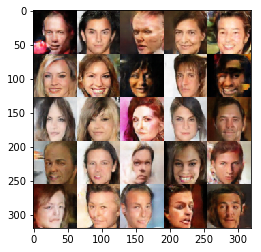

Epoch 11/20... Discriminator Loss: 2.2103... Generator Loss: 0.1785
Epoch 11/20... Discriminator Loss: 1.2189... Generator Loss: 0.6130
Epoch 11/20... Discriminator Loss: 1.1929... Generator Loss: 0.6613
Epoch 11/20... Discriminator Loss: 1.0995... Generator Loss: 0.6104
Epoch 11/20... Discriminator Loss: 0.7871... Generator Loss: 1.4073
Epoch 11/20... Discriminator Loss: 2.0835... Generator Loss: 0.1869


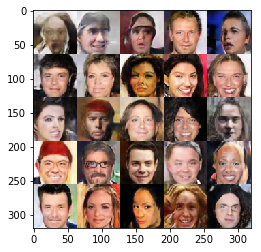

Epoch 11/20... Discriminator Loss: 1.8759... Generator Loss: 0.2456
Epoch 11/20... Discriminator Loss: 1.1743... Generator Loss: 0.7067
Epoch 11/20... Discriminator Loss: 1.3319... Generator Loss: 0.4973
Epoch 11/20... Discriminator Loss: 0.8408... Generator Loss: 1.0382
Epoch 11/20... Discriminator Loss: 0.6280... Generator Loss: 1.4131
Epoch 11/20... Discriminator Loss: 0.4728... Generator Loss: 3.3072


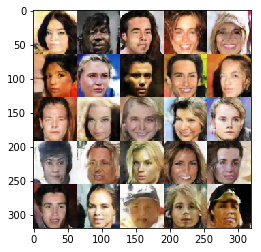

Epoch 12/20... Discriminator Loss: 2.2091... Generator Loss: 0.1868
Epoch 12/20... Discriminator Loss: 0.7426... Generator Loss: 1.0577
Epoch 12/20... Discriminator Loss: 0.9835... Generator Loss: 0.7521
Epoch 12/20... Discriminator Loss: 1.2207... Generator Loss: 0.6063
Epoch 12/20... Discriminator Loss: 0.4818... Generator Loss: 1.4198
Epoch 12/20... Discriminator Loss: 2.1406... Generator Loss: 0.1977


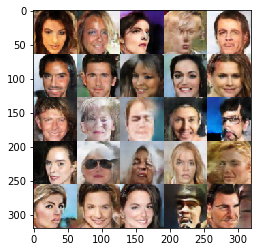

Epoch 12/20... Discriminator Loss: 0.4225... Generator Loss: 1.9387
Epoch 12/20... Discriminator Loss: 0.7413... Generator Loss: 1.1205
Epoch 12/20... Discriminator Loss: 1.7408... Generator Loss: 6.1321
Epoch 12/20... Discriminator Loss: 1.0172... Generator Loss: 0.7776
Epoch 12/20... Discriminator Loss: 0.6480... Generator Loss: 1.1980
Epoch 12/20... Discriminator Loss: 1.5586... Generator Loss: 0.4261


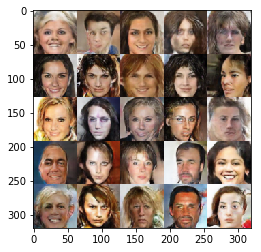

Epoch 12/20... Discriminator Loss: 1.2989... Generator Loss: 0.6456
Epoch 12/20... Discriminator Loss: 1.0491... Generator Loss: 0.7902
Epoch 12/20... Discriminator Loss: 1.3404... Generator Loss: 0.5172
Epoch 13/20... Discriminator Loss: 1.0897... Generator Loss: 0.7337
Epoch 13/20... Discriminator Loss: 1.7748... Generator Loss: 0.3029
Epoch 13/20... Discriminator Loss: 1.3328... Generator Loss: 0.5047


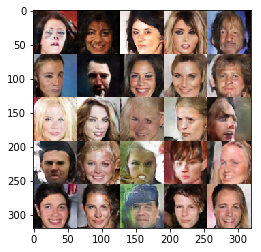

Epoch 13/20... Discriminator Loss: 0.5231... Generator Loss: 1.2833
Epoch 13/20... Discriminator Loss: 1.1483... Generator Loss: 1.5120
Epoch 13/20... Discriminator Loss: 0.8705... Generator Loss: 0.8543
Epoch 13/20... Discriminator Loss: 0.6709... Generator Loss: 3.8891
Epoch 13/20... Discriminator Loss: 1.8642... Generator Loss: 0.2857
Epoch 13/20... Discriminator Loss: 0.5589... Generator Loss: 1.7682


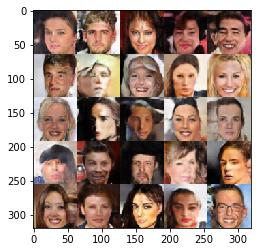

Epoch 13/20... Discriminator Loss: 2.0961... Generator Loss: 0.2205
Epoch 13/20... Discriminator Loss: 1.4277... Generator Loss: 0.5873
Epoch 13/20... Discriminator Loss: 1.2389... Generator Loss: 0.6439
Epoch 13/20... Discriminator Loss: 1.8040... Generator Loss: 0.2893
Epoch 13/20... Discriminator Loss: 0.7396... Generator Loss: 1.1193
Epoch 13/20... Discriminator Loss: 1.6756... Generator Loss: 0.3401


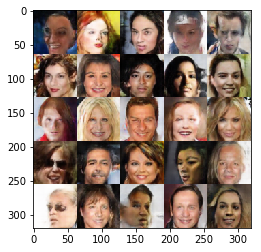

Epoch 13/20... Discriminator Loss: 2.0047... Generator Loss: 0.2861
Epoch 14/20... Discriminator Loss: 1.6217... Generator Loss: 0.4241
Epoch 14/20... Discriminator Loss: 0.6981... Generator Loss: 1.2712
Epoch 14/20... Discriminator Loss: 0.6715... Generator Loss: 1.3140
Epoch 14/20... Discriminator Loss: 1.9535... Generator Loss: 0.3684
Epoch 14/20... Discriminator Loss: 0.9302... Generator Loss: 0.8055


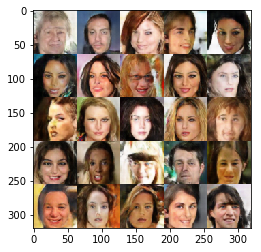

Epoch 14/20... Discriminator Loss: 0.9783... Generator Loss: 0.8065
Epoch 14/20... Discriminator Loss: 1.7337... Generator Loss: 0.3508
Epoch 14/20... Discriminator Loss: 1.5846... Generator Loss: 0.4064
Epoch 14/20... Discriminator Loss: 1.1382... Generator Loss: 1.5050
Epoch 14/20... Discriminator Loss: 0.5614... Generator Loss: 1.8156
Epoch 14/20... Discriminator Loss: 0.9948... Generator Loss: 0.7505


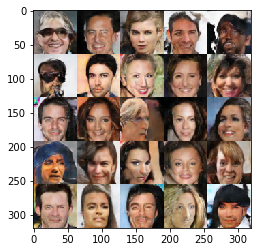

Epoch 14/20... Discriminator Loss: 0.9765... Generator Loss: 0.8140
Epoch 14/20... Discriminator Loss: 0.6373... Generator Loss: 1.0888
Epoch 14/20... Discriminator Loss: 0.6636... Generator Loss: 1.0906
Epoch 14/20... Discriminator Loss: 1.2637... Generator Loss: 0.6776
Epoch 14/20... Discriminator Loss: 0.8790... Generator Loss: 0.9512
Epoch 15/20... Discriminator Loss: 1.5486... Generator Loss: 0.3753


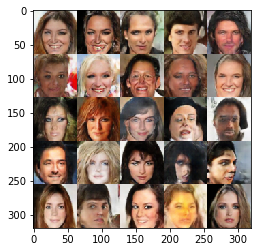

Epoch 15/20... Discriminator Loss: 1.1232... Generator Loss: 0.6808
Epoch 15/20... Discriminator Loss: 1.2818... Generator Loss: 0.5121
Epoch 15/20... Discriminator Loss: 0.7138... Generator Loss: 1.0249
Epoch 15/20... Discriminator Loss: 2.2197... Generator Loss: 0.2399
Epoch 15/20... Discriminator Loss: 0.3036... Generator Loss: 2.3118
Epoch 15/20... Discriminator Loss: 2.0077... Generator Loss: 0.2898


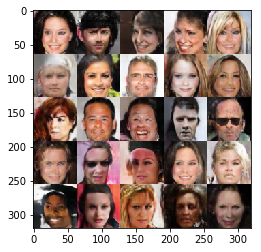

Epoch 15/20... Discriminator Loss: 0.6037... Generator Loss: 1.4177
Epoch 15/20... Discriminator Loss: 3.0105... Generator Loss: 0.0839
Epoch 15/20... Discriminator Loss: 2.1234... Generator Loss: 0.2325
Epoch 15/20... Discriminator Loss: 1.5587... Generator Loss: 0.4139
Epoch 15/20... Discriminator Loss: 1.9164... Generator Loss: 0.3265
Epoch 15/20... Discriminator Loss: 0.5413... Generator Loss: 1.6908


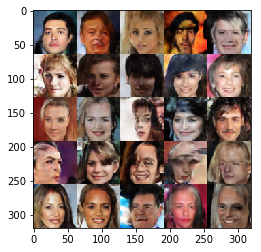

Epoch 15/20... Discriminator Loss: 1.2553... Generator Loss: 0.4969
Epoch 15/20... Discriminator Loss: 1.0987... Generator Loss: 0.7254
Epoch 15/20... Discriminator Loss: 0.4964... Generator Loss: 1.4366
Epoch 16/20... Discriminator Loss: 0.5315... Generator Loss: 1.4387
Epoch 16/20... Discriminator Loss: 0.8762... Generator Loss: 2.2148
Epoch 16/20... Discriminator Loss: 0.9999... Generator Loss: 0.7422


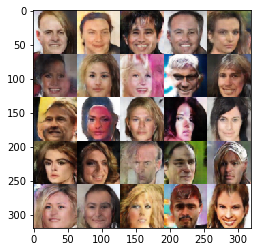

Epoch 16/20... Discriminator Loss: 0.7254... Generator Loss: 1.0287
Epoch 16/20... Discriminator Loss: 1.4336... Generator Loss: 0.4928
Epoch 16/20... Discriminator Loss: 1.1886... Generator Loss: 0.6473
Epoch 16/20... Discriminator Loss: 1.4811... Generator Loss: 0.4640
Epoch 16/20... Discriminator Loss: 1.2186... Generator Loss: 0.6615
Epoch 16/20... Discriminator Loss: 0.6892... Generator Loss: 1.1430


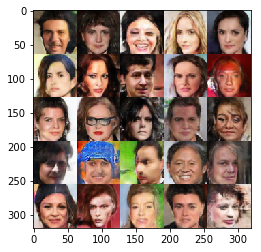

Epoch 16/20... Discriminator Loss: 0.5642... Generator Loss: 2.4036
Epoch 16/20... Discriminator Loss: 0.8617... Generator Loss: 1.1584
Epoch 16/20... Discriminator Loss: 2.0834... Generator Loss: 0.2937
Epoch 16/20... Discriminator Loss: 2.2332... Generator Loss: 0.2474
Epoch 16/20... Discriminator Loss: 0.5084... Generator Loss: 1.3987
Epoch 16/20... Discriminator Loss: 2.0536... Generator Loss: 0.3068


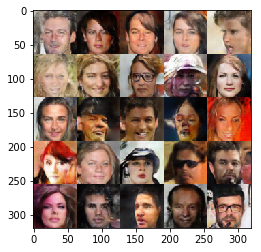

Epoch 16/20... Discriminator Loss: 0.8994... Generator Loss: 0.8520
Epoch 17/20... Discriminator Loss: 0.4881... Generator Loss: 1.5852
Epoch 17/20... Discriminator Loss: 0.6143... Generator Loss: 1.3552
Epoch 17/20... Discriminator Loss: 0.8078... Generator Loss: 1.0343
Epoch 17/20... Discriminator Loss: 1.3775... Generator Loss: 0.5442
Epoch 17/20... Discriminator Loss: 1.2856... Generator Loss: 0.6828


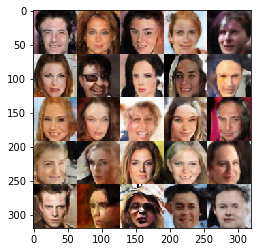

Epoch 17/20... Discriminator Loss: 0.6385... Generator Loss: 1.2336
Epoch 17/20... Discriminator Loss: 1.1721... Generator Loss: 0.6837
Epoch 17/20... Discriminator Loss: 1.1582... Generator Loss: 0.7027
Epoch 17/20... Discriminator Loss: 1.2921... Generator Loss: 0.5390
Epoch 17/20... Discriminator Loss: 1.1179... Generator Loss: 0.7049
Epoch 17/20... Discriminator Loss: 1.0495... Generator Loss: 0.8149


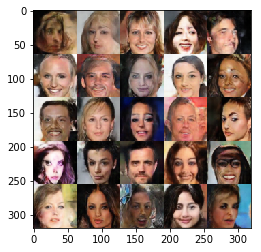

Epoch 17/20... Discriminator Loss: 0.8870... Generator Loss: 1.0058
Epoch 17/20... Discriminator Loss: 2.5629... Generator Loss: 0.1815
Epoch 17/20... Discriminator Loss: 1.2248... Generator Loss: 0.5709
Epoch 17/20... Discriminator Loss: 0.8471... Generator Loss: 0.9305
Epoch 18/20... Discriminator Loss: 0.9693... Generator Loss: 0.8919
Epoch 18/20... Discriminator Loss: 0.8574... Generator Loss: 0.9419


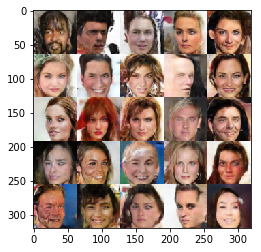

Epoch 18/20... Discriminator Loss: 0.4554... Generator Loss: 1.8535
Epoch 18/20... Discriminator Loss: 1.0403... Generator Loss: 0.7838
Epoch 18/20... Discriminator Loss: 2.0925... Generator Loss: 0.2193
Epoch 18/20... Discriminator Loss: 0.6810... Generator Loss: 1.1225
Epoch 18/20... Discriminator Loss: 1.8472... Generator Loss: 0.2680
Epoch 18/20... Discriminator Loss: 1.7323... Generator Loss: 0.3798


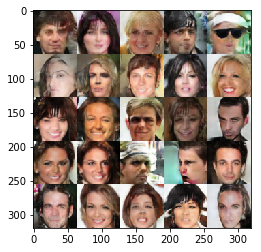

Epoch 18/20... Discriminator Loss: 2.9822... Generator Loss: 6.5415
Epoch 18/20... Discriminator Loss: 0.2439... Generator Loss: 2.9066
Epoch 18/20... Discriminator Loss: 0.8969... Generator Loss: 0.8668
Epoch 18/20... Discriminator Loss: 0.7342... Generator Loss: 1.0660
Epoch 18/20... Discriminator Loss: 2.1518... Generator Loss: 0.2269
Epoch 18/20... Discriminator Loss: 0.9220... Generator Loss: 0.8917


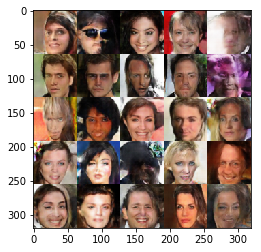

Epoch 18/20... Discriminator Loss: 0.5173... Generator Loss: 1.5905
Epoch 18/20... Discriminator Loss: 1.2737... Generator Loss: 0.5709
Epoch 19/20... Discriminator Loss: 1.0527... Generator Loss: 0.7810
Epoch 19/20... Discriminator Loss: 0.7573... Generator Loss: 1.0422
Epoch 19/20... Discriminator Loss: 0.3978... Generator Loss: 2.2920
Epoch 19/20... Discriminator Loss: 2.0537... Generator Loss: 0.3453


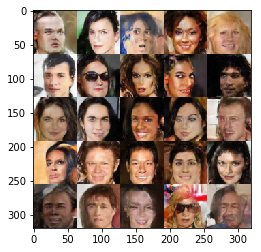

Epoch 19/20... Discriminator Loss: 0.7879... Generator Loss: 1.0083
Epoch 19/20... Discriminator Loss: 0.7151... Generator Loss: 1.1881
Epoch 19/20... Discriminator Loss: 0.7759... Generator Loss: 1.1796
Epoch 19/20... Discriminator Loss: 2.0154... Generator Loss: 0.2664
Epoch 19/20... Discriminator Loss: 0.5823... Generator Loss: 1.4445
Epoch 19/20... Discriminator Loss: 0.5325... Generator Loss: 1.9679


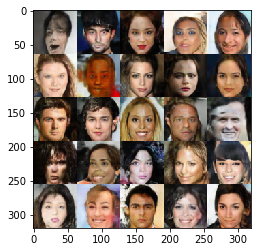

Epoch 19/20... Discriminator Loss: 1.4388... Generator Loss: 0.4880
Epoch 19/20... Discriminator Loss: 0.6745... Generator Loss: 1.0448
Epoch 19/20... Discriminator Loss: 1.0094... Generator Loss: 0.7729
Epoch 19/20... Discriminator Loss: 1.9409... Generator Loss: 0.3243
Epoch 19/20... Discriminator Loss: 2.9999... Generator Loss: 0.0898
Epoch 19/20... Discriminator Loss: 0.4196... Generator Loss: 4.7924


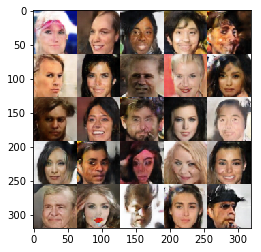

Epoch 20/20... Discriminator Loss: 1.3607... Generator Loss: 0.5632
Epoch 20/20... Discriminator Loss: 0.9854... Generator Loss: 0.7993
Epoch 20/20... Discriminator Loss: 0.8954... Generator Loss: 0.9904
Epoch 20/20... Discriminator Loss: 1.2667... Generator Loss: 0.6283
Epoch 20/20... Discriminator Loss: 0.6887... Generator Loss: 1.2052
Epoch 20/20... Discriminator Loss: 0.6072... Generator Loss: 1.4067


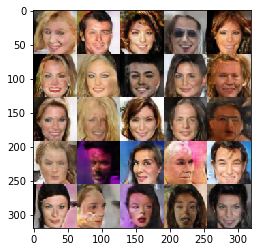

Epoch 20/20... Discriminator Loss: 1.1924... Generator Loss: 0.6796
Epoch 20/20... Discriminator Loss: 1.2352... Generator Loss: 0.6248
Epoch 20/20... Discriminator Loss: 0.7644... Generator Loss: 1.0684
Epoch 20/20... Discriminator Loss: 1.0049... Generator Loss: 0.7684
Epoch 20/20... Discriminator Loss: 0.3104... Generator Loss: 2.0316
Epoch 20/20... Discriminator Loss: 2.2126... Generator Loss: 0.2226


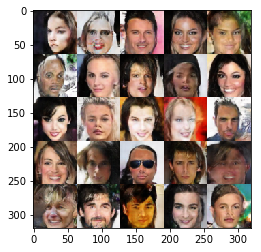

Epoch 20/20... Discriminator Loss: 1.2153... Generator Loss: 0.6164
Epoch 20/20... Discriminator Loss: 0.4143... Generator Loss: 1.7698
Epoch 20/20... Discriminator Loss: 0.2630... Generator Loss: 2.2067
Epoch 20/20... Discriminator Loss: 1.1576... Generator Loss: 0.6808


In [11]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 20

celeba_dataset = dcgan_helper.Dataset(
    'celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')), image_width=64, image_height=64)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)